In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. 데이터 불러오기(상관분석 O)

In [2]:
df_filtered=pd.read_excel('데이터2_독립변수전체_최종_24추가_필터링.xlsx')

df_filtered

,판매일,판매수량,소비자물가지수,생활물가지수,기준금리,"음료,차류",경제성장률(실질GDP성장률),평균 발주 일자,총 발주건수,남성 실업률,전체 실업률,여성 실업률,빵.케익.과자류
0,2021-01-01,4,101.04,101.20,0.5,0.000000,2.5,24.600000,44.000000,5.0,5.7,6.7,0.00
1,2021-01-05,2885,101.04,101.20,0.5,0.000000,2.5,53.073554,35.000000,5.0,5.7,6.7,0.00
2,2021-01-12,77,101.04,101.20,0.5,0.500000,2.5,37.087500,35.375000,5.0,5.7,6.7,0.75
3,2021-01-19,474,101.04,101.20,0.5,0.000000,2.5,25.990909,38.636364,5.0,5.7,6.7,0.00
4,2021-01-26,1057,101.04,101.20,0.5,0.000000,2.5,29.174545,33.818182,5.0,5.7,6.7,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2024-05-28,1689,114.10,116.62,3.5,0.526316,2.3,27.850980,41.039216,3.1,3.0,2.7,0.00
219,2024-06-04,1453,113.84,116.62,3.5,0.000000,2.3,29.332407,38.166667,3.0,2.9,2.8,0.00
220,2024-06-11,1010,113.84,116.62,3.5,0.573770,2.3,27.209000,41.600000,3.0,2.9,2.8,0.00
221,2024-06-18,937,113.84,116.62,3.5,0.000000,2.3,22.784270,42.325843,3.0,2.9,2.8,0.00


In [3]:
#데이터셋 변수 확인
print(df_filtered.columns.tolist())

['판매일', '판매수량', '소비자물가지수', '생활물가지수', '기준금리', '음료,차류', '경제성장률(실질GDP성장률)', '평균 발주 일자', '총 발주건수', '남성 실업률', '전체 실업률', '여성 실업률', '빵.케익.과자류']


## 2. 변수 설정 및 스케일링

In [4]:
# 판매일 인덱스 처리
df = df_filtered.copy()
df['판매일'] = pd.to_datetime(df['판매일'])

df.set_index('판매일', inplace=True)

# 독립변수, 종속 변수 지정
X = df.drop(columns=['판매수량'])
y = df['판매수량']

# 독립변수 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## 3. 시퀀스 데이터 생성 및 데이터 분할

In [5]:
# 시계열 데이터 예측을 위한 생성 함수
def create_sequences(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 시퀀스 데이터 생성 (4주 단위)
time_steps = 4
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)

In [6]:
# 학습 데이터와 테스트 데이터 분리 (2024년 1월 이전까지는 학습, 이후는 테스트)
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

## 4. 모델 함수 생성

In [7]:
# LSTM 모델 구축
def build_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# GRU 모델 구축
def build_gru_model(units=50):
    model = Sequential()
    model.add(GRU(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

## 5. 모델 학습 및 성능 평가

In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae

# LSTM 모델 학습 및 평가
lstm_model = build_lstm_model()
y_pred_lstm, rmse_lstm, mae_lstm = train_and_evaluate_model(lstm_model, X_train, y_train, X_test, y_test)

# GRU 모델 학습 및 평가
gru_model = build_gru_model()
y_pred_gru, rmse_gru, mae_gru = train_and_evaluate_model(gru_model, X_train, y_train, X_test, y_test)

print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")
print(f"GRU RMSE: {rmse_gru}, MAE: {mae_gru}")

/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
LSTM RMSE: 742.573467226079, MAE: 638.2780512029475
GRU RMSE: 714.904986137865, MAE: 608.0502249977806


## 6. 마무리

In [13]:
# 판매일 인덱스 생성
pred_dates = df.index[-len(y_test):]  # 테스트 데이터의 판매일 인덱스

# 실제값, LSTM 예측값, GRU 예측값으로 데이터프레임 생성
results = pd.DataFrame({
    '판매일': pred_dates,
    '실제값': y_test,
    'GRU 예측값': y_pred_gru.flatten(),
    'LSTM 예측값': y_pred_lstm.flatten()  # 1D 배열로 변환    # 1D 배열로 변환
})

# 인덱스를 판매일로 설정
results.set_index('판매일', inplace=True)

# 결과 데이터프레임 출력
results

,실제값,GRU 예측값,LSTM 예측값
판매일,,,
2023-08-29,1612,899.260010,886.086609
2023-09-05,2033,873.923279,882.771423
2023-09-12,2059,986.166748,1002.800415
2023-09-19,1542,962.766846,971.161133
2023-09-26,760,972.917480,992.991272
2023-10-03,1503,1023.453857,1063.866211
2023-10-10,1548,960.108704,995.721680
2023-10-17,1748,1020.986633,1042.584595
2023-10-24,2195,941.446960,978.574951


In [14]:
results = results.reset_index()

results

,판매일,실제값,GRU 예측값,LSTM 예측값
0,2023-08-29,1612,899.260010,886.086609
1,2023-09-05,2033,873.923279,882.771423
2,2023-09-12,2059,986.166748,1002.800415
3,2023-09-19,1542,962.766846,971.161133
4,2023-09-26,760,972.917480,992.991272
5,2023-10-03,1503,1023.453857,1063.866211
6,2023-10-10,1548,960.108704,995.721680
7,2023-10-17,1748,1020.986633,1042.584595
8,2023-10-24,2195,941.446960,978.574951
9,2023-10-31,2051,1021.177002,1051.386108


In [15]:
# 2024년도 데이터만 필터링
results_2024 = results[results['판매일'].dt.year == 2024]

# 월별로 그룹화하고 합산
monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()

# 'index' 칼럼 삭제
monthly_sales = monthly_sales.drop(columns=['index'], errors='ignore')

monthly_sales

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_11055/2854464769.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()


,판매일,실제값,GRU 예측값,LSTM 예측값
0,2024-01-31,3859,5700.888672,6296.511719
1,2024-02-29,3146,4577.342285,5311.955566
2,2024-03-31,2385,4413.018555,5013.180664
3,2024-04-30,5231,5469.509766,6136.764160
4,2024-05-31,3432,4345.666992,4834.106445
5,2024-06-30,4687,4731.109375,5333.137207


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_11055/3074105200.py:17: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_11055/3074105200.py:17: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_11055/3074105200.py:17: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
findfont: Font family 'Malgun Gothic' not found.
findfont: Font

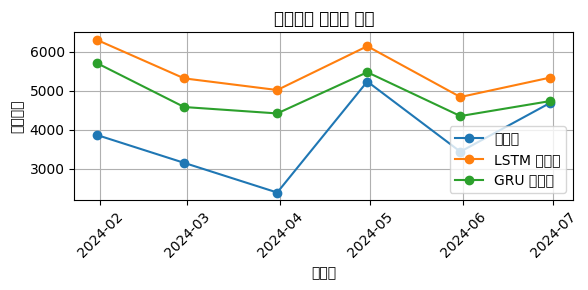

In [16]:
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')

#라인 차트 시각화
plt.figure(figsize=(6, 3))
plt.plot(monthly_sales['판매일'], monthly_sales['실제값'], marker='o', label='실제값')
plt.plot(monthly_sales['판매일'], monthly_sales['LSTM 예측값'], marker='o', label='LSTM 예측값')
plt.plot(monthly_sales['판매일'], monthly_sales['GRU 예측값'], marker='o', label='GRU 예측값')

plt.title('실제값과 예측값 비교')
plt.xlabel('판매일')
plt.ylabel('판매수량')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()